In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

def clean_mbta_reliability(file_path):
    """
    Cleans the MBTA reliability dataset with a focus on bus data for
    performance and equity analysis.

    Args:
        file_path (str): The file path to the raw CSV data.

    Returns:
        pandas.DataFrame: A cleaned DataFrame.
    """

    # Load Data
    # Load the dataset
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    print(f"Original data shape: {df.shape}")

    # Filter for Bus Data
    # Keep only 'Bus' data.
    df_bus = df[df['mode_type'] == 'Bus'].copy()
    print(f"Shape after filtering for 'Bus': {df_bus.shape}")


    # Handle Dates
    # Convert service_date to datetime objects for filtering and feature engineering
    df_bus['service_date'] = pd.to_datetime(df_bus['service_date'])

    # Filter for project's time frame (2018-present)
    df_bus = df_bus[df_bus['service_date'] >= '2018-01-01'].copy()
    print(f"Shape after filtering for dates >= 2018: {df_bus.shape}")


    # Handle Missing Values
    # Check for missing values
    # print("\n--- Missing Value Counts ---")
    # print(df_bus.isnull().sum())

    # 'cancelled_numerator' might have NaNs, which means 0 cancellations.
    # Assuming NaN = 0.
    df_bus['cancelled_numerator'] = df_bus['cancelled_numerator'].fillna(0)

    # If otp_denominator is null, the row is useless.
    df_bus = df_bus.dropna(subset=['otp_numerator', 'otp_denominator'])
    print(f"Shape after dropping key nulls: {df_bus.shape}")


    # Calculate reliability metric

    # Avoid division by zero. If denominator is 0, reliability is undefined (NaN).
    df_bus['reliability_metric'] = df_bus['otp_numerator'] / df_bus['otp_denominator']

    # Handle cases where division resulted in NaN (e.g., 0/0)
    # If 0/0, it means no service was observed, so no reliability score.
    # We can't say it was 100% reliable. Dropping these may be best.
    df_bus = df_bus.dropna(subset=['reliability_metric'])




    # Select and rename columns
    # Keep only the columns relevant to analysis
    relevant_cols = [
        'service_date',
        'gtfs_route_id',
        'gtfs_route_short_name',
        'route_category',
        'peak_offpeak_ind',
        'metric_type',
        'otp_numerator',
        'otp_denominator',
        'reliability_metric',
        'cancelled_numerator'
    ]

    # Ensure all desired columns exist before trying to select them
    final_cols = [col for col in relevant_cols if col in df_bus.columns]
    df_cleaned = df_bus[final_cols].copy()

    print(f"Final cleaned data shape: {df_cleaned.shape}")

    return df_cleaned

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

def plot_static_timeseries(cleaned_df):
    """
    Creates a static time-series plot of bus reliability using matplotlib.
    """
    # Resample by month ('ME') to get a smoother trend
    # We group by 'peak_offpeak_ind' first, then resample each group
    df_monthly = (
        cleaned_df.set_index('service_date')
        .groupby('peak_offpeak_ind')['reliability_metric']
        .resample('ME')
        .mean()
        .reset_index()
    )

    # Pivot the data for easier plotting (PEAK and OFF_PEAK as columns)
    df_pivot = df_monthly.pivot(
        index='service_date',
        columns='peak_offpeak_ind',
        values='reliability_metric'
    )

    # Create the Plot
    print("Generating plot...")
    fig, ax = plt.subplots(figsize=(15, 9))

    # Instead of df_pivot.plot(), we use ax.plot() directly
    # This gives matplotlib explicit control over the date axis
    ax.plot(df_pivot.index, df_pivot['OFF_PEAK'], '.-', markersize=4, label='OFF_PEAK')
    ax.plot(df_pivot.index, df_pivot['PEAK'], '.-', markersize=4, label='PEAK')

    # Add Formatting

    # Add a vertical line for the pandemic
    pandemic_date = pd.to_datetime('2020-03-01')
    ax.axvline(pandemic_date, color='red', linestyle='--', label='Pandemic Start (Mar 2020)')

    # Set titles and labels
    ax.set_title('Average Monthly Bus Reliability (2018-Present)', fontsize=16)
    ax.set_ylabel('Reliability', fontsize=12)
    ax.set_xlabel('Year', fontsize=12)

    # Format Y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax.set_ylim(0.4, 1.0) # Adjust as needed to see variation

    # Set major ticks to appear every 6 months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    # Set the format of the major labels to 'YYYY-MM' (e.g., "2019-01")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Set minor ticks to appear every month (without labels)
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    # Rotate the X-axis labels to prevent overlap
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Add legend and grid
    ax.legend(title='Time Period')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout() # Adjust plot to prevent label overlap

    # Save the Plot
    plot_filename = 'static_reliability_timeseries.png'
    plt.savefig(plot_filename)
    print(f"\nSuccess! Plot saved to {plot_filename}")

def plot_bottom_5_reliability_routes(cleaned_df):
    """
    Finds the 5 routes with the lowest average reliability
    and plots their time-series data in a small-multiple chart.
    """

    # Find the 5 best routes
    # We use 'gtfs_route_short_name' as it's human-readable (e.g., "39")
    avg_reliability = cleaned_df.groupby('gtfs_route_short_name')['reliability_metric'].mean()
    bottom_5_routes = avg_reliability.sort_values().tail(5)

    bottom_5_route_names = bottom_5_routes.index

    # Prepare data for plotting
    # Filter main dataframe to only these 5 routes
    df_filtered = cleaned_df[cleaned_df['gtfs_route_short_name'].isin(bottom_5_route_names)]

    # Resample this data by month
    df_monthly = (
        df_filtered.set_index('service_date')
        .groupby(['gtfs_route_short_name', 'peak_offpeak_ind'])['reliability_metric']
        .resample('ME')
        .mean()
    ).reset_index()

    # Pivot for easier plotting
    df_pivot = df_monthly.pivot_table(
        index=['service_date', 'gtfs_route_short_name'],
        columns='peak_offpeak_ind',
        values='reliability_metric'
    ).reset_index()

    #Create the "Small Multiples" Plot

    # Create 5 subplots, stacked vertically (5 rows, 1 column)
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20), sharex=True, sharey=True)

    pandemic_date = pd.to_datetime('2020-03-01')

    # Loop through each route and its assigned subplot (ax)
    for i, route_name in enumerate(bottom_5_route_names):
        ax = axes[i]

        # Get data for just this one route
        route_data = df_pivot[df_pivot['gtfs_route_short_name'] == route_name]

        # Plot PEAK and OFF_PEAK
        ax.plot(route_data['service_date'], route_data['OFF_PEAK'], '.-', label='OFF_PEAK')
        ax.plot(route_data['service_date'], route_data['PEAK'], '.-', label='PEAK')

        # Add pandemic line
        ax.axvline(pandemic_date, color='red', linestyle='--', label='Pandemic Start (Mar 2020)')

        # Formatting
        # Add a title to each subplot
        ax.set_title(f"Route: {route_name}", fontsize=14, loc='left')
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Format Y-axis as percentage
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Final Global Formatting
    # Set a shared Y-axis label
    fig.text(0.04, 0.5, 'Reliability', va='center', rotation='vertical', fontsize=12)

    # Set a shared X-axis label (only on the bottom plot)
    ax.set_xlabel('Month and Year', fontsize=12)

    # Set shared X-axis date formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Set a single main title for the whole figure
    fig.suptitle('Monthly Reliability for 5 Worst-Performing Routes', fontsize=20, y=1.02)

    plt.tight_layout() # Adjust plots to prevent label overlap

    # Save the Plot
    plot_filename = 'bottom_5_routes_timeseries.png'
    plt.savefig(plot_filename, bbox_inches='tight') # bbox_inches ensures title isn't cut off

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_operational_model(cleaned_df):
    """
    Builds a baseline Random Forest model to predict bus reliability
    based on operational and temporal features.
    """
    print("\n--- Building Baseline Operational Model ---")

    # 1. Feature Engineering
    model_df = cleaned_df.copy()

    # *** FIX IS HERE ***
    # Ensure service_date is datetime and strip timezone info to avoid TypeError
    model_df['service_date'] = pd.to_datetime(model_df['service_date']).dt.tz_localize(None)

    # Temporal Features
    model_df['month'] = model_df['service_date'].dt.month
    model_df['day_of_week'] = model_df['service_date'].dt.dayofweek # 0=Monday, 6=Sunday
    model_df['is_weekend'] = model_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Contextual Features
    # Pandemic flag (After March 1, 2020)
    # Now this comparison will work safely
    pandemic_start = pd.Timestamp('2020-03-01')
    model_df['is_pandemic'] = model_df['service_date'].apply(
        lambda x: 1 if x >= pandemic_start else 0
    )

    # Operational Features
    # Convert 'PEAK'/'OFF_PEAK' to 1/0
    model_df['is_peak'] = model_df['peak_offpeak_ind'].apply(lambda x: 1 if x == 'PEAK' else 0)

    # Encode Route Name
    le = LabelEncoder()
    model_df['route_encoded'] = le.fit_transform(model_df['gtfs_route_short_name'])

    # Define Predictors (X) and Target (y)
    features = ['month', 'day_of_week', 'is_weekend', 'is_pandemic', 'is_peak', 'route_encoded']
    X = model_df[features]
    y = model_df['reliability_metric']

    print(f"Training with features: {features}")

    # 2. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Train Model
    rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    # 4. Evaluate
    y_pred = rf_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2:  {r2:.4f}")

    # 5. Feature Importance Visualization
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance: What drives Delay Risk?")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
    plt.tight_layout()

    # Save the plot
    plt.savefig('feature_importance.png')
    print("Feature importance plot saved to 'feature_importance.png'")

    return rf_model

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_classification_performance(model, X_test, y_test):
    """
    Generates a 3-panel dashboard to evaluate the classification model:
    1. ROC Curve
    2. Precision-Recall Curve
    3. Prediction Probability Distribution
    """
    print("\n--- Generating Model Performance Visualizations ---")

    # Get probability predictions (needed for curves)
    # [:, 1] gets the probability of class 1 ("Unreliable")
    y_probs = model.predict_proba(X_test)[:, 1]

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # --- Plot 1: ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc="lower right")
    axes[0].grid(alpha=0.3)

    # --- Plot 2: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_test, y_probs)

    axes[1].plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
    axes[1].set_xlabel('Recall (Sensitivity)')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].legend(loc="lower left")
    axes[1].grid(alpha=0.3)

    # --- Plot 3: Probability Distribution ---
    # This shows how confident the model is.
    # Ideally, you want peaks near 0 (confident reliable) and 1 (confident unreliable).
    sns.histplot(y_probs, bins=20, kde=True, ax=axes[2], color='purple')
    axes[2].set_title('Distribution of Predicted Delay Probabilities')
    axes[2].set_xlabel('Predicted Probability of Being Unreliable')
    axes[2].set_ylabel('Count of Test Samples')
    axes[2].axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
    axes[2].legend()

    plt.tight_layout()

    # Save the plot
    filename = 'model_performance_dashboard.png'
    plt.savefig(filename)
    print(f"Performance dashboard saved to '{filename}'")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def build_delay_probability_model(cleaned_df):
    """
    Builds a Classification Model to predict the Likelihood of "Unreliable Service".
    Target: 1 if Reliability < Threshold, 0 otherwise.
    """
    print("\n--- Building Delay Probability (Classification) Model ---")

    model_df = cleaned_df.copy()

    # 1. Fix Dates (Timezone issue)
    model_df['service_date'] = pd.to_datetime(model_df['service_date']).dt.tz_localize(None)

    # 2. Define "Unreliable"
    # If reliability is below 70%, we consider it a "High Delay" day.
    # You can adjust this threshold (0.70, 0.75, etc.)
    THRESHOLD = 0.70
    model_df['is_unreliable'] = model_df['reliability_metric'].apply(lambda x: 1 if x < THRESHOLD else 0)

    print(f"Defining 'Unreliable' as reliability score < {THRESHOLD:.0%}")
    print(f"Class Balance:\n{model_df['is_unreliable'].value_counts(normalize=True)}")

    # 3. Feature Engineering (Same as before)
    model_df['month'] = model_df['service_date'].dt.month
    model_df['day_of_week'] = model_df['service_date'].dt.dayofweek
    model_df['is_weekend'] = model_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    pandemic_start = pd.Timestamp('2020-03-01')
    model_df['is_pandemic'] = model_df['service_date'].apply(lambda x: 1 if x >= pandemic_start else 0)
    model_df['is_peak'] = model_df['peak_offpeak_ind'].apply(lambda x: 1 if x == 'PEAK' else 0)

    le = LabelEncoder()
    model_df['route_encoded'] = le.fit_transform(model_df['gtfs_route_short_name'])

    # 4. Train Model
    features = ['month', 'day_of_week', 'is_weekend', 'is_pandemic', 'is_peak', 'route_encoded']
    X = model_df[features]
    y = model_df['is_unreliable']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Using Random Forest Classifier
    clf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf_model.fit(X_train, y_train)

    # 5. Evaluate
    y_pred = clf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    clf_model.fit(X_train, y_train)

    print(f"\nClassification Accuracy: {accuracy:.2%}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # 6. Example: How to get "Likelihood" (Probability)
    # Let's verify the likelihood for the first 5 test cases
    probs = clf_model.predict_proba(X_test)[:5]
    print("\nExample Predictions (Probability of Delay):")
    for i, p in enumerate(probs):
        # p[1] is the probability of class 1 (Unreliable)
        print(f"Test Case {i+1}: {p[1]:.1%} chance of being unreliable")

    visualize_classification_performance(clf_model, X_test, y_test)

    return clf_model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def process_spatial_features(pati_file_path):
    """
    Loads PATI bus stop data, parses the 'Routes' column, and aggregates
    spatial/infrastructure features for each bus route.
    """
    print("\n--- Processing Spatial Infrastructure Features (PATI Data) ---")

    try:
        # Load the CSV version of the PATI data
        # We use 'converters' to ensure Routes are read as strings, not numbers
        df_pati = pd.read_csv(pati_file_path, converters={'Routes': str})
    except FileNotFoundError:
        print(f"Error: PATI file not found at {pati_file_path}")
        return None

    # 1. Parse the 'Routes' column
    # The 'Routes' column looks like "1, 10, 39". We need to split this.
    # We drop rows where Routes is NaN
    df_pati = df_pati.dropna(subset=['Routes'])

    # 'Explode' the dataframe: Create a separate row for each route served by a stop
    # Step A: Turn "1, 10" into list ["1", "10"]
    df_pati['route_list'] = df_pati['Routes'].str.split(', ')

    # Step B: Explode the list so one stop can belong to multiple routes
    df_exploded = df_pati.explode('route_list')

    # Rename for clarity
    df_exploded = df_exploded.rename(columns={'route_list': 'gtfs_route_short_name'})

    # Strip whitespace just in case
    df_exploded['gtfs_route_short_name'] = df_exploded['gtfs_route_short_name'].str.strip()

    # 2. Engineer Infrastructure Features per Route
    # We group by Route Name and calculate summary statistics

    route_stats = df_exploded.groupby('gtfs_route_short_name').agg(
        total_stops=('Stop_ID', 'count'),

        # Calculate percentage of stops that are "Critical" priority (bad condition)
        critical_stops=('PATI_Prior', lambda x: (x == 'Critical').sum()),

        # Calculate total amenities (Proxy for investment level)
        total_benches=('SeatNum17', 'sum'),
        total_shelters=('BikeRks17', 'sum'), # Using BikeRks as placeholder if Shelter isn't explicit

        # Calculate spatial spread (Rough proxy for route length)
        min_lat=('Latitude', 'min'),
        max_lat=('Latitude', 'max'),
        min_lon=('Longitude', 'min'),
        max_lon=('Longitude', 'max')
    ).reset_index()

    # Derived Features
    route_stats['pct_critical_stops'] = route_stats['critical_stops'] / route_stats['total_stops']
    route_stats['amenities_per_stop'] = route_stats['total_benches'] / route_stats['total_stops']

    # Rough approximation of route bounding box diagonal (spatial extent)
    route_stats['spatial_extent'] = np.sqrt(
        (route_stats['max_lat'] - route_stats['min_lat'])**2 +
        (route_stats['max_lon'] - route_stats['min_lon'])**2
    )

    features_to_keep = ['gtfs_route_short_name', 'total_stops', 'pct_critical_stops',
                        'amenities_per_stop', 'spatial_extent']

    print(f"Extracted spatial features for {len(route_stats)} unique routes.")
    return route_stats[features_to_keep]


def build_spatial_model(cleaned_reliability_df, pati_features_df):
    """
    Merges Reliability Data with Spatial Features and trains a model.
    """
    print("\n--- Building Spatial/Infrastructure Model ---")

    # 1. Merge Datasets
    # Join on 'gtfs_route_short_name'
    merged_df = pd.merge(cleaned_reliability_df, pati_features_df,
                         on='gtfs_route_short_name', how='inner')

    print(f"Data shape after merging spatial features: {merged_df.shape}")

    if merged_df.empty:
        print("Error: No common routes found between Reliability and PATI data. Check route names.")
        return None

    # 2. Prepare Features
    # We include our previous temporal features PLUS the new spatial ones
    merged_df['service_date'] = pd.to_datetime(merged_df['service_date']).dt.tz_localize(None)
    merged_df['month'] = merged_df['service_date'].dt.month
    merged_df['day_of_week'] = merged_df['service_date'].dt.dayofweek
    merged_df['is_peak'] = merged_df['peak_offpeak_ind'].apply(lambda x: 1 if x == 'PEAK' else 0)

    features = [
        'month', 'day_of_week', 'is_peak',  # Temporal
        'total_stops', 'pct_critical_stops', 'amenities_per_stop', 'spatial_extent' # Spatial/Infrastructure
    ]

    X = merged_df[features]
    y = merged_df['reliability_metric']

    # 3. Train Model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_spatial = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_spatial.fit(X_train, y_train)

    # 4. Evaluate
    y_pred = rf_spatial.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"Spatial Model R^2: {r2:.4f}")

    # 5. Feature Importance
    importances = rf_spatial.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("What Impacts Reliability? (Infrastructure vs. Time)")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.savefig('spatial_feature_importance.png')
    print("Spatial feature importance plot saved.")

    return rf_spatial

import geopandas as gpd
from shapely.geometry import Point

def integrate_demographics(pati_df, shapefile_path, acs_data_path):
    """
    Performs a Spatial Join to link Bus Stops -> Census Tracts -> Demographic Data.
    Aggregates this data to create 'Route-Level' demographic profiles.
    """
    print("\n--- Starting Equity Integration (Spatial Join) ---")

    # 1. Convert Bus Stops to a GeoDataFrame
    # We need to turn the Lat/Lon columns into geometric Points
    geometry = [Point(xy) for xy in zip(pati_df['Longitude'], pati_df['Latitude'])]
    stops_geo = gpd.GeoDataFrame(pati_df, geometry=geometry)

    # Set the coordinate reference system (CRS) to WGS84 (standard Lat/Lon)
    stops_geo.set_crs(epsg=4326, inplace=True)

    # 2. Load Census Tract Shapefile
    try:
        tracts_geo = gpd.read_file(shapefile_path)
        # Ensure the shapefile is in the same projection as our stops
        tracts_geo = tracts_geo.to_crs(epsg=4326)
    except Exception as e:
        print(f"Error loading Shapefile: {e}")
        return None

    # 3. Load ACS Demographic Data
    # Assuming CSV has columns: ['GEOID', 'Median_Income', 'Pct_Minority', 'Pct_No_Vehicle']
    try:
        acs_df = pd.read_csv(acs_data_path, dtype={'GEOID': str})
    except FileNotFoundError:
        print(f"Error loading ACS Data: {acs_data_path}")
        return None

    # 4. Spatial Join (Point-in-Polygon)
    # This finds which Census Tract polygon each Bus Stop point is inside
    print("Performing spatial join (this may take a moment)...")
    stops_with_tracts = gpd.sjoin(stops_geo, tracts_geo, how="left", predicate="within")

    # 5. Merge with ACS Data
    # Join on GEOID (Tract ID)
    # Note: Ensure the column name for Tract ID matches in both files (often 'GEOID' or 'GEOID10')
    stops_with_demographics = pd.merge(stops_with_tracts, acs_df, on='GEOID', how='left')

    # 6. Aggregate by Route
    # We now have income/race data for every individual stop.
    # We need to average this to get a "Route Profile".

    # Explode routes again just to be safe (if not already done in pati_df input)
    # (Assuming pati_df came from our previous process_spatial_features function)

    route_demographics = stops_with_demographics.groupby('gtfs_route_short_name').agg(
        # Weighted average or simple mean of the demographics along the route
        route_avg_income=('Median_Income', 'mean'),
        route_pct_minority=('Pct_Minority', 'mean'),
        route_pct_no_vehicle=('Pct_No_Vehicle', 'mean'),
        stop_count=('Stop_ID', 'count')
    ).reset_index()

    print(f"Demographic profiles created for {len(route_demographics)} routes.")
    print(route_demographics.head())

    return route_demographics

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os

def map_stops_to_tracts(pati_path, tracts_path, output_dir):
    print("\n--- Starting Spatial Join (Stops -> Tracts) ---")

    # 1. Load PATI Bus Stops
    # Converters ensure 'Routes' is read as string
    try:
        df_pati = pd.read_csv(pati_path, converters={'Routes': str})
    except FileNotFoundError:
        print(f"Error: PATI file not found at {pati_path}")
        return None

    # Create GeoDataFrame from Lat/Lon
    geometry = [Point(xy) for xy in zip(df_pati['Longitude'], df_pati['Latitude'])]
    stops_geo = gpd.GeoDataFrame(df_pati, geometry=geometry)
    stops_geo.set_crs(epsg=4326, inplace=True)

    # 2. Load Census Tracts (Shapefile)
    print(f"Loading tracts from: {tracts_path}")
    try:
        tracts_geo = gpd.read_file(tracts_path)

        # --- ROBUST GEOMETRY HANDLING ---
        # 1. Identify the current geometry column name (could be 'geometry', 'GEOMETRY', 'the_geom', etc.)
        current_geom_col = tracts_geo.geometry.name

        # 2. Reproject if necessary (Standardize to EPSG:4326)
        if tracts_geo.crs and tracts_geo.crs.to_string() != 'EPSG:4326':
            print(f"Reprojecting tracts from {tracts_geo.crs.to_string()} to EPSG:4326...")
            tracts_geo = tracts_geo.to_crs(epsg=4326)

        # 3. Standardize Column Names (Uppercase)
        # We rename the columns, but we must handle the geometry column carefully
        new_columns = []
        for col in tracts_geo.columns:
            new_columns.append(col.upper())

        tracts_geo.columns = new_columns

        # 4. *** CRITICAL FIX ***
        # We just renamed 'geometry' to 'GEOMETRY'. We must tell GeoPandas about this change!
        # The new geometry column name is the uppercase version of whatever it was before
        new_geom_col = current_geom_col.upper()
        tracts_geo = tracts_geo.set_geometry(new_geom_col)

    except Exception as e:
        print(f"Error loading Shapefile: {e}")
        return None

    # 3. Spatial Join
    print("Joining stops to tracts...")
    try:
        # predicate='within' checks if the stop is INSIDE the tract
        stops_with_tracts = gpd.sjoin(stops_geo, tracts_geo, how="left", predicate="within")
    except Exception as e:
        print(f"Spatial Join Failed: {e}")
        return None

    # 4. Save Result
    # Robustly find the ID column (could be GEOID20, GEOID, etc.)
    possible_id_cols = ['GEOID20', 'GEOID', 'TRACTCE20', 'geoid20']
    found_id_col = next((col for col in possible_id_cols if col in stops_with_tracts.columns), None)

    relevant_cols = ['Stop_ID', 'Stop_Name', 'Routes', 'gtfs_route_short_name', 'NAMELSAD20']
    if found_id_col:
        relevant_cols.append(found_id_col)

    # Filter columns
    final_cols = [c for c in relevant_cols if c in stops_with_tracts.columns]

    # Drop duplicates (in case a point touches the boundary of two tracts)
    final_df = stops_with_tracts[final_cols].drop_duplicates(subset=['Stop_ID'])

    # Standardize the ID column name for the rest of the pipeline
    if found_id_col:
        final_df = final_df.rename(columns={found_id_col: 'geoid20'})

    output_path = os.path.join(output_dir, 'stops_with_tract_ids.csv')
    final_df.to_csv(output_path, index=False)

    print(f"Success! Saved to {output_path}")
    print(f"Total Stops Mapped: {len(final_df)}")

    # Quick Check: How many stops missed a tract? (Should be low/zero for statewide map)
    missing_tracts = final_df['geoid20'].isnull().sum()
    print(f"Stops without a matching Tract ID: {missing_tracts}")

    return final_df


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def create_route_demographics(mapped_stops_path, demographics_path):
    """
    Joins Mapped Stops with Census Data to create a "Demographic Profile" for each route.
    Example: "Route 39 serves neighborhoods with Avg Income $55k and 60% Minority."
    """
    print("\n--- Creating Route Demographic Profiles ---")

    # 1. Load Data
    try:
        # Load Stops (Result of Step 1)
        stops_df = pd.read_csv(mapped_stops_path, converters={'Routes': str, 'geoid20': str})

        # Load Demographics (Result of Step 2)
        census_df = pd.read_csv(demographics_path, dtype={'GEOID': str})
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        return None

    # 2. Prepare Stops Data (Explode Routes)
    # A single stop might serve "1, 10, 39". We need to count it for ALL those routes.
    stops_df = stops_df.dropna(subset=['Routes'])
    stops_df['route_list'] = stops_df['Routes'].str.split(', ')
    stops_exploded = stops_df.explode('route_list')

    # Clean Route Name
    stops_exploded['gtfs_route_short_name'] = stops_exploded['route_list'].str.strip()

    # 3. Merge Stops with Census Data
    # Join on Census Tract ID (geoid20 from stops = GEOID from census)
    merged_stops = pd.merge(stops_exploded, census_df, left_on='geoid20', right_on='GEOID', how='inner')

    print(f"Linked {len(merged_stops)} stop-route pairs to demographic data.")

    # 4. Aggregate by Route
    # We calculate the AVERAGE characteristics of the neighborhoods the route passes through.
    route_profile = merged_stops.groupby('gtfs_route_short_name').agg(
        # Key Demographics
        route_avg_income=('Median_Income', 'mean'),
        route_pct_minority=('Pct_Minority', 'mean'),
        route_pct_no_vehicle=('Pct_No_Vehicle', 'mean'),

        # Context (How many stops did we find?)
        stops_with_data=('Stop_ID', 'count')
    ).reset_index()

    print(f"Created profiles for {len(route_profile)} routes.")
    print("Example Profile (Head):")
    print(route_profile.head())

    return route_profile


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

def build_equity_model(cleaned_reliability_df, route_demographics_df):
    """
    Trains the Final Equity Model and generates an advanced dashboard:
    1. Feature Importance (Who drives reliability?)
    2. Actual vs Predicted (How good is the model?)
    3. Partial Dependence (What is the direction of the bias?)
    """
    print("\n--- Building Final Equity Model & Advanced Visualizations ---")

    # 1. Merge Reliability with Demographics
    full_df = pd.merge(cleaned_reliability_df, route_demographics_df,
                       on='gtfs_route_short_name', how='inner')

    if full_df.empty:
        print("Error: Merge failed. No common routes found.")
        return None

    # 2. Feature Engineering
    full_df['service_date'] = pd.to_datetime(full_df['service_date']).dt.tz_localize(None)
    full_df['month'] = full_df['service_date'].dt.month
    full_df['day_of_week'] = full_df['service_date'].dt.dayofweek
    full_df['is_peak'] = full_df['peak_offpeak_ind'].apply(lambda x: 1 if x == 'PEAK' else 0)

    # Select Features (Including the new demographic ones)
    features = [
        'month', 'day_of_week', 'is_peak',
        'route_avg_income', 'route_pct_no_vehicle'
    ]

    X = full_df[features].fillna(full_df[features].mean())
    y = full_df['reliability_metric']

    # 3. Train Model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_equity = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_equity.fit(X_train, y_train)

    # 4. Evaluate
    y_pred = rf_equity.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\nEquity Model Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2:  {r2:.4f}")

    # --- VISUALIZATION DASHBOARD ---

    # Figure 1: Feature Importance (The "Drivers")
    importances = rf_equity.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    colors = ['firebrick' if 'route' in features[i] else 'gray' for i in indices]
    plt.bar(range(X.shape[1]), importances[indices], align="center", color=colors)
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45, ha='right')
    plt.title("Feature Importance: Demographics vs. Operations")
    plt.tight_layout()
    plt.savefig('equity_1_feature_importance.png')

    # Figure 2: Actual vs Predicted (The "Accuracy")
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.1, color='teal', s=10)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Diagonal line
    plt.xlabel('Actual Reliability')
    plt.ylabel('Predicted Reliability')
    plt.title(f'Actual vs. Predicted (R^2 = {r2:.2f})')
    plt.grid(True, alpha=0.3)
    plt.savefig('equity_2_actual_vs_predicted.png')

    # Figure 3: Partial Dependence Plot (The "Direction of Bias")
    # This shows: As Income increases (X-axis), what happens to Reliability (Y-axis)?
    print("Generating Partial Dependence Plots (this takes a moment)...")

    # We only plot the top 3 interesting features to save space
    features_to_plot = ['route_avg_income', 'route_pct_no_vehicle', 'is_peak']

    fig, ax = plt.subplots(figsize=(15, 5))
    PartialDependenceDisplay.from_estimator(
        rf_equity, X_train, features_to_plot,
        kind='average', ax=ax, line_kw={'color': 'firebrick', 'linewidth': 2}
    )
    plt.suptitle("Partial Dependence: How Demographic Changes Affect Reliability", y=1.05)
    plt.savefig('equity_3_partial_dependence.png')

    print("All equity visualizations saved.")

    return rf_equity

In [ ]:
import pandas as pd
import os

def process_all_census_data(dp03_path, dp04_path, dp05_path, output_path):
    """
    Parses and merges ACS DP03 (Income), DP04 (Vehicles), and DP05 (Demographics).
    Creates a single master demographics file with:
    - Median_Income
    - Pct_Minority
    - Pct_No_Vehicle
    """
    print("\n--- Processing All Census Data (DP03, DP04, DP05) ---")

    # --- Helper to load and clean GEOID ---
    def load_clean(path):
        try:
            df = pd.read_csv(path, header=0, low_memory=False)
            df = df.drop(0) # Drop description row
            # Clean GEOID ("1400000US25025..." -> "25025...")
            df['GEOID'] = df['GEO_ID'].astype(str).str.split('US').str[-1]
            return df
        except FileNotFoundError:
            print(f"Error: File not found at {path}")
            return None

    # 1. Load All Files
    df3 = load_clean(dp03_path) # Income
    df4 = load_clean(dp04_path) # Vehicles
    df5 = load_clean(dp05_path) # Race

    if df3 is None or df4 is None or df5 is None:
        return None

    # 2. Extract Specific Columns
    # Note: These column IDs are standard for ACS 2023 5-Year.
    # If your metadata differs, check the .txt files.

    # DP03: Median Household Income (DP03_0062E)
    df3_clean = df3[['GEOID', 'DP03_0062E']].copy()
    df3_clean['Median_Income'] = pd.to_numeric(df3_clean['DP03_0062E'], errors='coerce')

    # DP04: % No Vehicle
    # DP04_0057E = Occupied Housing Units
    # DP04_0058E = No vehicle available
    df4_clean = df4[['GEOID', 'DP04_0057E', 'DP04_0058E']].copy()
    df4_clean['Housing_Units'] = pd.to_numeric(df4_clean['DP04_0057E'], errors='coerce')
    df4_clean['No_Vehicle_Count'] = pd.to_numeric(df4_clean['DP04_0058E'], errors='coerce')
    df4_clean['Pct_No_Vehicle'] = df4_clean['No_Vehicle_Count'] / df4_clean['Housing_Units']

    # DP05: % Minority
    # DP05_0001E = Total Population
    # DP05_0077E = White alone, not Hispanic or Latino
    df5_clean = df5[['GEOID', 'DP05_0001E', 'DP05_0077E']].copy()
    df5_clean['Total_Pop'] = pd.to_numeric(df5_clean['DP05_0001E'], errors='coerce')
    df5_clean['White_Non_Hisp'] = pd.to_numeric(df5_clean['DP05_0077E'], errors='coerce')

    # Calculate Minority (Total - WhiteNonHisp)
    df5_clean['Minority_Pop'] = df5_clean['Total_Pop'] - df5_clean['White_Non_Hisp']
    df5_clean['Pct_Minority'] = df5_clean['Minority_Pop'] / df5_clean['Total_Pop']

    # 3. Merge Them All
    # Merge on GEOID
    merged = pd.merge(df3_clean[['GEOID', 'Median_Income']],
                      df5_clean[['GEOID', 'Pct_Minority']],
                      on='GEOID', how='inner')

    merged = pd.merge(merged,
                      df4_clean[['GEOID', 'Pct_No_Vehicle']],
                      on='GEOID', how='inner')

    # 4. Clean Up
    # Drop rows where any key metric is NaN
    final_df = merged.dropna(subset=['Median_Income', 'Pct_Minority', 'Pct_No_Vehicle'])

    final_df.to_csv(output_path, index=False)
    print(f"Success! Combined demographics saved to: {output_path}")
    print(final_df.head())

    return final_df

In [ ]:
def build_final_equity_model(cleaned_reliability_df, route_demographics_df):
    print("\n--- Building Final Clean Equity Model ---")

    # 1. Merge
    full_df = pd.merge(cleaned_reliability_df, route_demographics_df,
                       on='gtfs_route_short_name', how='inner')

    # 2. Feature Engineering
    full_df['service_date'] = pd.to_datetime(full_df['service_date']).dt.tz_localize(None)
    full_df['month'] = full_df['service_date'].dt.month
    full_df['day_of_week'] = full_df['service_date'].dt.dayofweek
    full_df['is_peak'] = full_df['peak_offpeak_ind'].apply(lambda x: 1 if x == 'PEAK' else 0)

    # 3. SELECT FEATURES (Dropping Minority due to data quality issues)
    features = [
        'month', 'day_of_week', 'is_peak',
        'route_avg_income',
        'route_pct_no_vehicle'
    ]

    print(f"Training with CLEAN features: {features}")

    X = full_df[features].fillna(full_df[features].mean())
    y = full_df['reliability_metric']

    # 4. Train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_final.fit(X_train, y_train)

    # 5. Evaluate
    print(f"R^2: {r2_score(y_test, rf_final.predict(X_test)):.4f}")

    # 6. Generate The "Money Shot" Plots

    # A. Feature Importance
    plt.figure(figsize=(8, 5))
    importances = rf_final.feature_importances_
    indices = np.argsort(importances)[::-1]
    colors = ['firebrick' if 'route' in features[i] else 'gray' for i in indices]
    plt.bar(range(X.shape[1]), importances[indices], align="center", color=colors)
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45, ha='right')
    plt.title("Final Feature Importance: Income vs. Operations")
    plt.tight_layout()
    plt.savefig('final_feature_importance.png')

    # B. Partial Dependence (Income Only - for clarity)
    fig, ax = plt.subplots(figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(
        rf_final, X_train, ['route_avg_income'],
        kind='average', ax=ax, line_kw={'color': 'firebrick', 'linewidth': 3}
    )
    plt.title("Impact of Neighborhood Income on Bus Reliability", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig('final_income_pdp.png')

    print("Final plots saved.")
    return rf_final


--- Starting Full Project Pipeline (All Datasets) ---
Original data shape: (979208, 13)
Shape after filtering for 'Bus': (850885, 13)
Shape after filtering for dates >= 2018: (648505, 13)
Shape after dropping key nulls: (648505, 13)
Final cleaned data shape: (646596, 10)

--- Building Baseline Operational Model ---
Training with features: ['month', 'day_of_week', 'is_weekend', 'is_pandemic', 'is_peak', 'route_encoded']

Model Performance:
RMSE: 0.1176
R^2:  0.4231
Feature importance plot saved to 'feature_importance.png'

--- Building Delay Probability (Classification) Model ---
Defining 'Unreliable' as reliability score < 70%
Class Balance:
is_unreliable
1    0.521429
0    0.478571
Name: proportion, dtype: float64

Classification Accuracy: 75.85%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74     61816
           1       0.76      0.79      0.77     67504

    accuracy                           0.76    129320
 

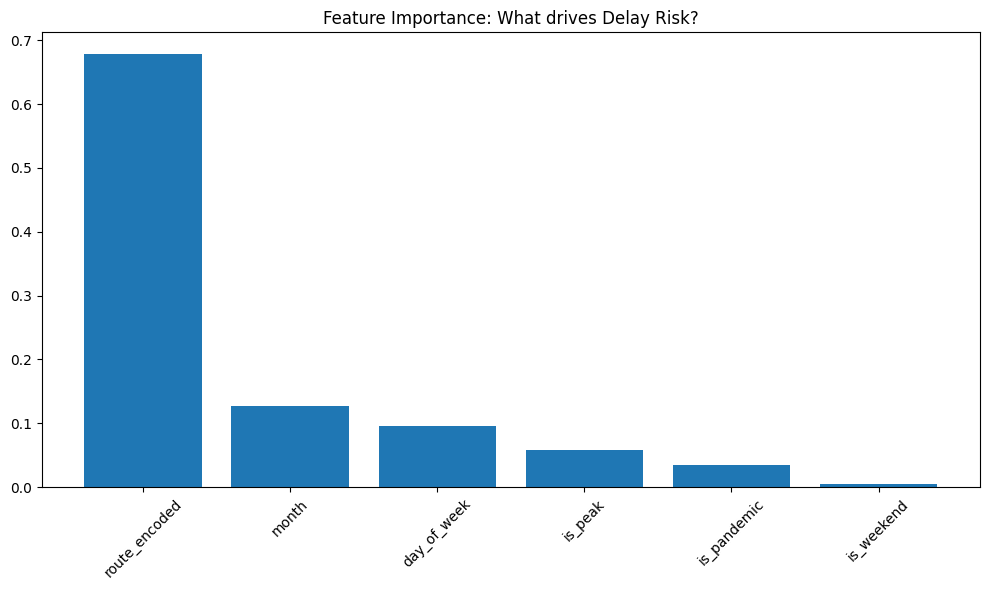

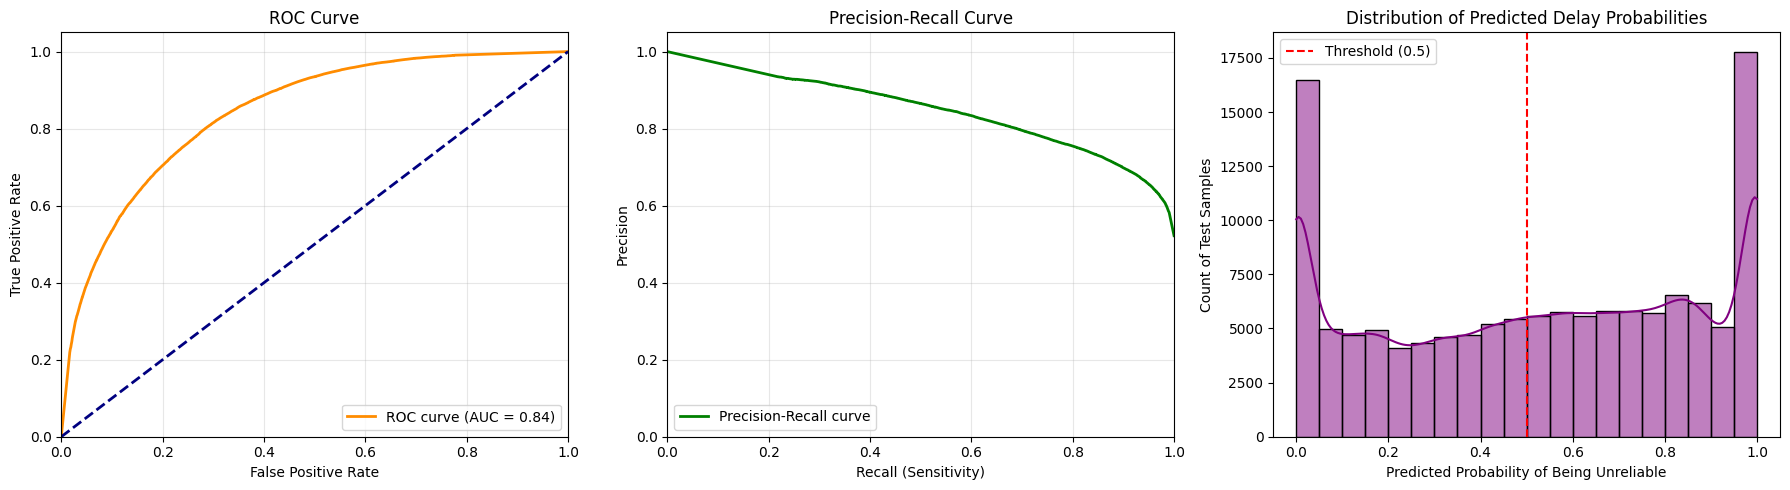

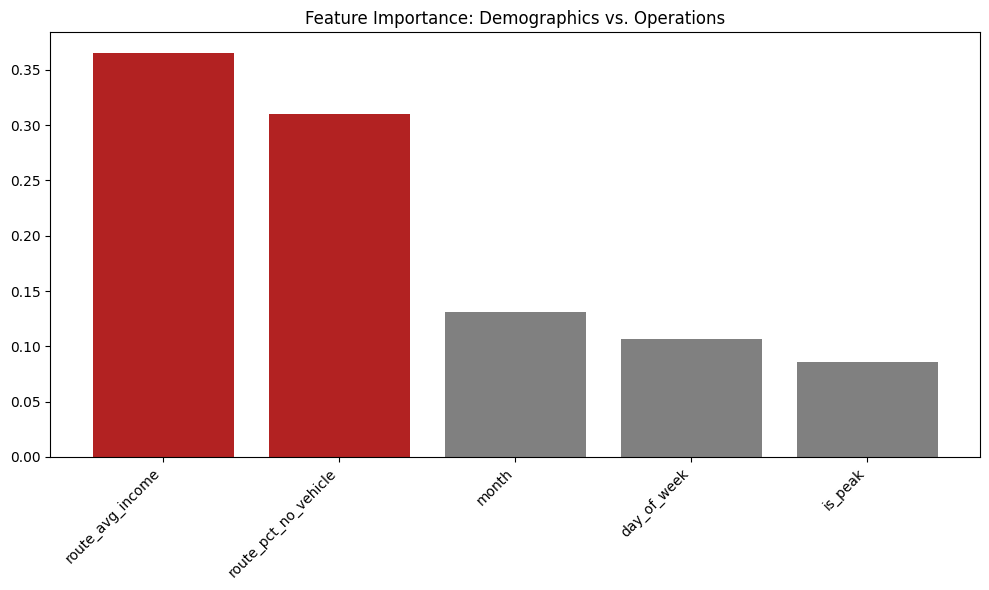

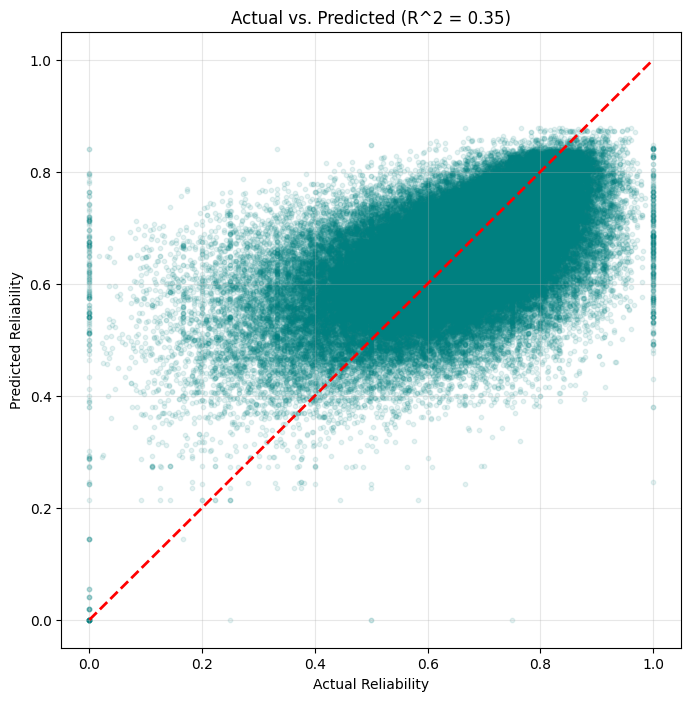

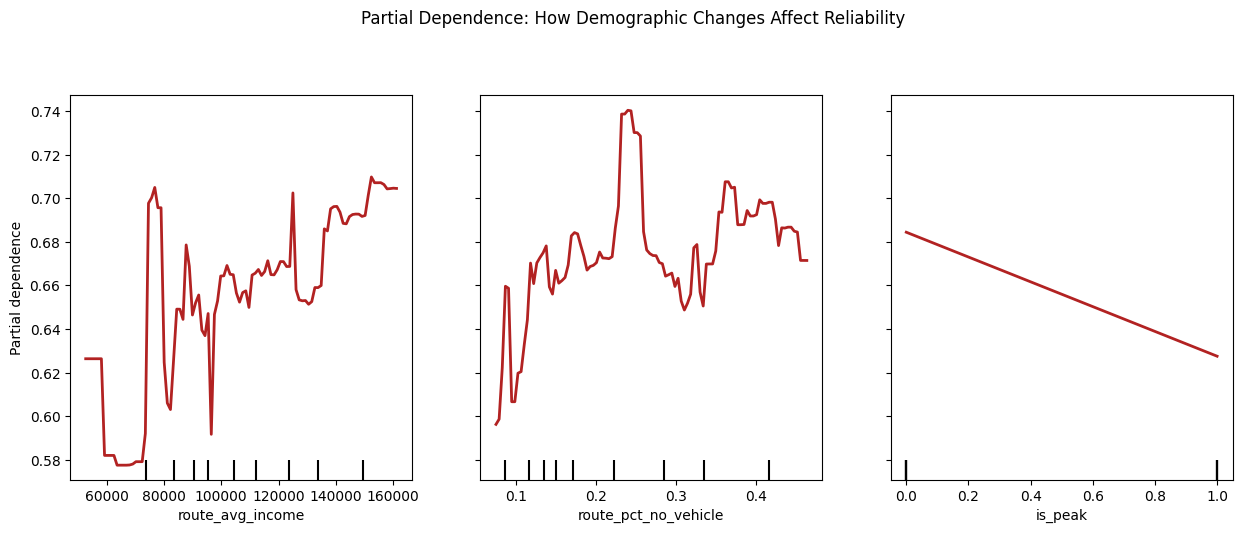

In [ ]:
# --- Updated Execution Block (Full Equity Edition) ---

import os

# 1. Define Paths
BASE_DIR = '/content/drive/MyDrive/CS506/data'

# Data Files
RELIABILITY_FILE = os.path.join(BASE_DIR, 'reliability', 'MBTA_Bus_CommuterRail_RapidTransit_Reliability.csv')
PATI_FILE = os.path.join(BASE_DIR, 'spatial_data', 'PATI_Bus_Stops.csv')
TRACTS_FILE = os.path.join(BASE_DIR, 'spatial_data', 'ma_census_tracts', 'ma_census_tracts.shp')

# Census CSVs (Points to your new folders)
# Note: Adjust filenames if your unzipped files are named slightly differently
DP03_FILE = os.path.join(BASE_DIR, 'spatial_data', 'DP03_5years', 'DP03-Data.csv')
DP04_FILE = os.path.join(BASE_DIR, 'spatial_data', 'DP04_5years', 'DP04-Data.csv')
DP05_FILE = os.path.join(BASE_DIR, 'spatial_data', 'DP05_5years', 'DP05-Data.csv')

# Outputs
SPATIAL_OUTPUT_DIR = os.path.join(BASE_DIR, 'spatial_data')
MAPPED_STOPS_FILE = os.path.join(SPATIAL_OUTPUT_DIR, 'stops_with_tract_ids.csv')
DEMOGRAPHICS_FILE = os.path.join(SPATIAL_OUTPUT_DIR, 'ma_census_demographics.csv')


print("--- Starting Full Project Pipeline (All Datasets) ---")

# A. Reliability Data
cleaned_bus_data = clean_mbta_reliability(RELIABILITY_FILE)

if cleaned_bus_data is not None:

    # Run the Regression Model (Predicting specific score)
    build_operational_model(cleaned_bus_data)

    # Run the Classification Model (Predicting Risk Probability)
    build_delay_probability_model(cleaned_bus_data)



    # B. Map Stops
    map_stops_to_tracts(PATI_FILE, TRACTS_FILE, SPATIAL_OUTPUT_DIR)

    # C. Process All Census Data (Income + Race + Vehicles)
    # This creates the 'ma_census_demographics.csv' with all 3 columns
    process_all_census_data(DP03_FILE, DP04_FILE, DP05_FILE, DEMOGRAPHICS_FILE)

    # D. Create Route Profiles
    route_demographics = create_route_demographics(MAPPED_STOPS_FILE, DEMOGRAPHICS_FILE)

    # E. Train Final Model
    if route_demographics is not None:
        # Note: Ensure build_equity_model is using ALL features:
        # features = ['month', 'day_of_week', 'is_peak', 'route_avg_income', 'route_pct_minority', 'route_pct_no_vehicle']
        build_equity_model(cleaned_bus_data, route_demographics)

        #build_final_equity_model(cleaned_bus_data, route_demographics)

else:
    print("CRITICAL ERROR: Reliability data cleaning failed.")